📦 FAISS index loaded from disk.
🤖 Image Chatbot Ready. Type 'exit' to quit.




🔍 Enter heading or subheading:  kashmir


✅ Match found: extracted_forms/Admission_Brochure_PG__2024_2_6.pdf_page35.jpg


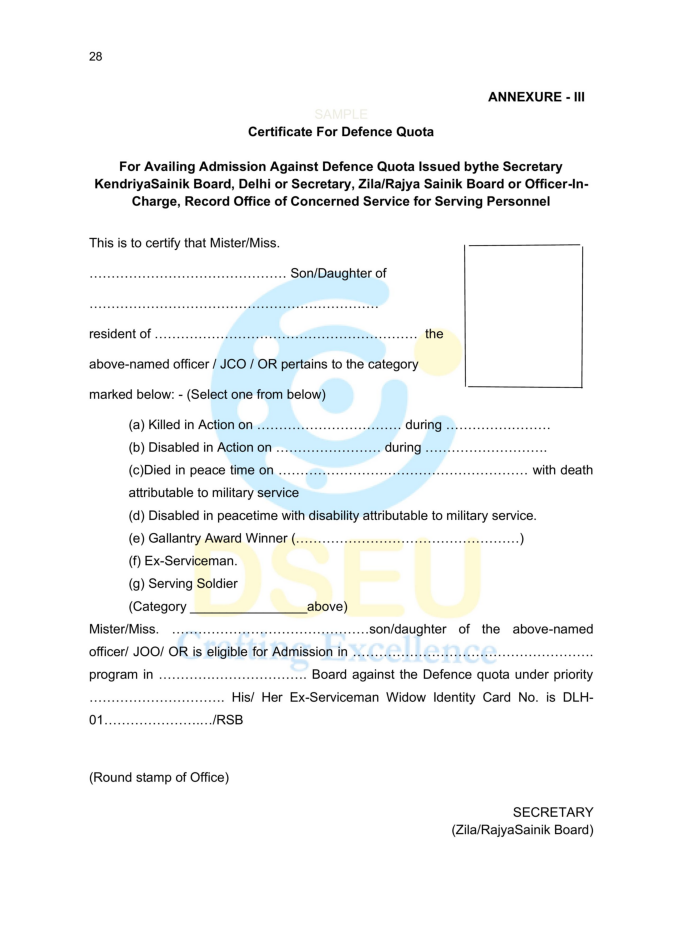


🔍 Enter heading or subheading:  kashmir migrate


✅ Match found: extracted_forms/Admission_Brochure_PG__2024_2_6.pdf_page35.jpg


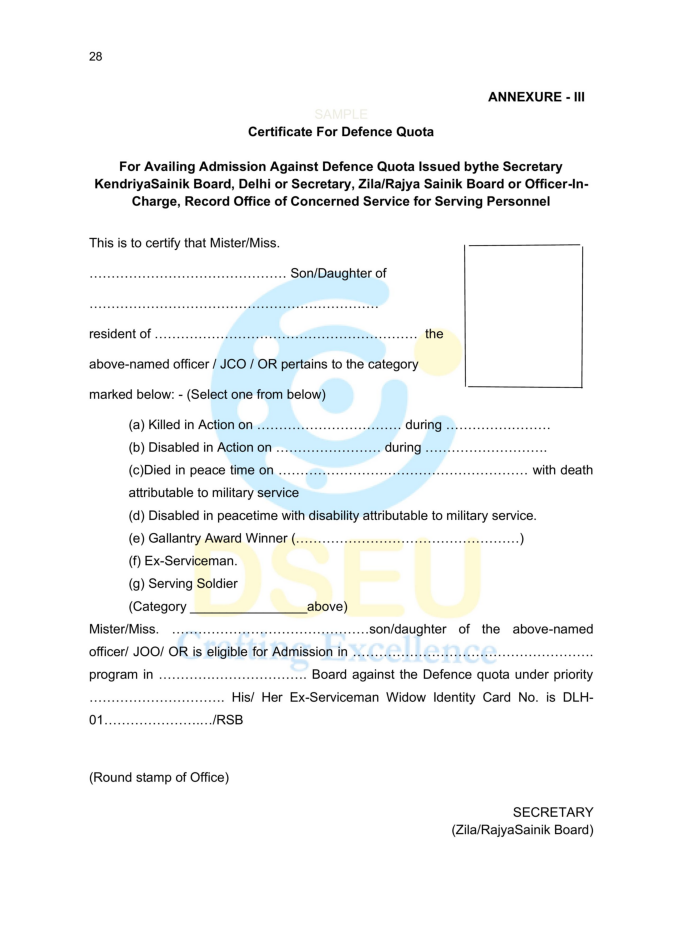


🔍 Enter heading or subheading:  exit


👋 Exiting chatbot.


In [3]:
import os
import pytesseract
import matplotlib.pyplot as plt
from PIL import Image
from fuzzywuzzy import fuzz
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.memory import ConversationBufferMemory

# Configs
INPUT_FOLDER = "extracted_forms"
VECTORSTORE_PATH = "embeddings_db/vectorstore.index"
EMBEDDING_MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"

# Embedding model
embedding_model = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)

# Memory (optional for future dialogue)
memory = ConversationBufferMemory()

def extract_text_from_top_quarter(image_path):
    try:
        image = Image.open(image_path)
        width, height = image.size
        cropped = image.crop((0, 0, width, height // 4))
        text = pytesseract.image_to_string(cropped, lang="eng")
        lines = [line.strip() for line in text.split("\n") if line.strip()]
        if len(lines) >= 2:
            return lines[0], lines[1]
        elif len(lines) == 1:
            return lines[0], "No Subheading Found"
        else:
            return "No Heading Found", "No Subheading Found"
    except Exception as e:
        return "Error", str(e)

def build_or_load_faiss_index():
    if os.path.exists(VECTORSTORE_PATH):
        print("📦 FAISS index loaded from disk.")
        vectorstore = FAISS.load_local(VECTORSTORE_PATH, embedding_model, allow_dangerous_deserialization=True)
        return vectorstore
        
    
    texts, metadatas = [], []

    for filename in os.listdir(INPUT_FOLDER):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            path = os.path.join(INPUT_FOLDER, filename)
            heading, subheading = extract_text_from_top_quarter(path)
            texts.append(f"{heading}. {subheading}")
            metadatas.append({"image_path": path})

    if texts:
        vectorstore = FAISS.from_texts(texts, embedding_model, metadatas=metadatas)
        vectorstore.save_local(VECTORSTORE_PATH)
        print("✅ FAISS index built and saved.")
        return vectorstore
    else:
        print("⚠️ No valid texts found.")
        return None

def fuzzy_match(user_input):
    best_match = None
    best_score = 0

    for filename in os.listdir(INPUT_FOLDER):
        if filename.lower().endswith((".png", ".jpg", ".jpeg")):
            path = os.path.join(INPUT_FOLDER, filename)
            heading, subheading = extract_text_from_top_quarter(path)
            score = max(
                fuzz.ratio(user_input.lower(), heading.lower()),
                fuzz.ratio(user_input.lower(), subheading.lower())
            )
            if score > best_score:
                best_score = score
                best_match = path

    return best_match

def faiss_search(user_input, vectorstore):
    try:
        results = vectorstore.similarity_search(user_input, k=1)
        if results:
            return results[0].metadata["image_path"]
    except Exception as e:
        print(f"⚠️ FAISS search error: {e}")
    return None

def display_image(image_path):
    try:
        image = Image.open(image_path)
        plt.close("all")
        fig, ax = plt.subplots(figsize=(10, 12))
        ax.imshow(image)
        ax.axis("off")
        plt.show()
    except Exception as e:
        print(f"⚠️ Error displaying image: {e}")

# === MAIN ===
vectorstore = build_or_load_faiss_index()

print("🤖 Image Chatbot Ready. Type 'exit' to quit.\n")
while True:
    user_input = input("\n🔍 Enter heading or subheading: ").strip()
    
    if user_input.lower() == "exit":
        print("👋 Exiting chatbot.")
        break

    # Step 1: Try FAISS
    image_path = faiss_search(user_input, vectorstore)

    # Step 2: If FAISS fails, fallback to fuzzy matching
    if not image_path:
        print("🤖 FAISS didn't find a match. Trying fuzzy matching...")
        image_path = fuzzy_match(user_input)

    if image_path:
        print(f"✅ Match found: {image_path}")
        display_image(image_path)
    else:
        print("⚠️ No matching image found.")
